# Load Data

In [301]:
import pandas as pd
import numpy as np

In [302]:
df = pd.read_csv("df.csv")

# ACF
- Manually calculate ACF and compare it against the plot created by statsmodels

In [303]:
from scipy import stats
import numpy as np
# Create function to calculate lagged correlation
def calc_corr(series, lag):
    return stats.pearsonr(series[:-lag], series[lag:])[0]


In [304]:
# Save the results for the first 10 lags
manual_acf = [1]
for i in range(1,10):
    manual_acf.append(np.round(calc_corr(series,i),2))
manual_acf = pd.Series(manual_acf)

NameError: name 'series' is not defined

NameError: name 'acf' is not defined

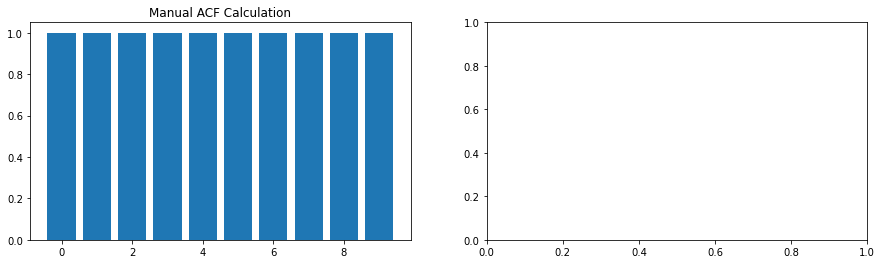

In [305]:
num_lags = 10

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,4)) 

# Create first plot (the manual plot)
ax1.bar(range(num_lags), manual_acf)
ax1.set_title("Manual ACF Calculation")

ax2.bar(range(num_lags), pd.Series(acf(series)[0:10]))
ax2.set_title("Automated ACF Calculation")

plt.show()

We can see the above two graphs are duplicates of each other. 

# PACF

In [306]:
pacf_vals = pacf(series)
num_lags = 25
plt.bar(range(num_lags), pacf_vals[:num_lags])
plt.title("PACF")
plt.show()

NameError: name 'pacf' is not defined

# ARMA from Scratch

In [307]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pd.options.mode.chained_assignment = None  # default='warn'
from statsmodels.tsa.arima_model import ARIMA


In [308]:
df = pd.read_csv('df.csv',parse_dates=True,index_col='date')
df = pd.DataFrame(df.groupby(df.index.strftime('%Y-%m')).sum()['amount'])
df.columns=['Value']

In [309]:
# train test split
train_index = int(int(0.8*len(df)))
# Train / Test
train = df[:train_index]
test = df[train_index:]

## Create Class Object: myARMA

In [310]:
class myARIMA:
    """
    The goal of this class is to clearly and manually create an ARIMA class,
    which matches the output of statsmodels' ARIMA class.  The syntax will 
    aim to be similar to sci-kit learn.  
    
    Note, this class is for illustrative purposes; therefore, it does not 
    attempt to optimize code run times.  Consequently, large data sets 
    should be not be used with this class.
    
    "Private" methods are declared first since that is where the crux of the
    math is done.  Those "private" methods are fed into public methods.
    """
    def __init__(self):
        pass
    
    def __calcConstant(self, y):
        self.mu = np.average(y)
        
        return self.mu
    
    def __AR(self, X, y):
        # Add intercept to X values -- this is the intercept calculated from __calcConstants
        X['Intercept'] = self.mu
        
        #Run linear regression to generate the coefficents of lagged terms
        import statsmodels.api as sm
        self.results = sm.OLS(y, X,hasconst=False).fit()        
        
        self.theta1 = self.results.params[0] # Save the coefficient term
        print(f"{self.mu:,.6f}", ", ", f"{self.theta1:,.6f}", " <<< self.mu, self.theta1")
        
        return [self.mu, self.theta1]
    
    def __MA(self):
        print("Need to build")
        
    def fit(self, df, p, d, q): 
        """
        Do not split the input parameters for the df into X and y because
        then the user would have to lag the variables themself.  This approach
        feels more similar to the sklearn interface.
        
        The fit method's only purpose is to split the df into X and y variables.
        """
        self.df = df
        self.p = p # number of AR terms
        self.d = d # the d is not incorporated into the model yet
        self.q = q # number of MA terms
        num_of_columns = len(self.df.columns)

        # Calculate the intercept/constant term
        self.mu = self.__calcConstant(self.df)

        #Generating the lagged p terms
        for i in range(1,self.p+1):
            self.df['Shifted_values_%d' % i ] = self.df.shift(self.p)
        
        # Create X and Y plus remove the NaN's that arose from lagging
        self.X = self.df.iloc[self.p:,1:]
        self.y = np.array(self.df.iloc[self.p:,0]).reshape(-1,p)
        
        self.__AR(self.X, self.y) # Pass X and y to the __AR method
        return 0
    
    def predict(self, test_data):
        self.test_data = test_data # Test needs to have one column containing the y-values
        #Generating the lagged p terms 
        for i in range(1,self.p+1):
            self.test_data['Shifted_values_%d' % i ] = self.test_data.iloc[:,0].shift(i)
        
        # Create X and Y
        X = np.array(self.test_data.iloc[self.p:,1:]) # p+1 to avoid NaN values, first colum so we're using lagged values
        y = np.array(self.test_data.iloc[self.p:,0])
        
        pred_values = self.mu + (X * self.theta1) # Calculate predicted values
        self.RMSE = np.sqrt(mean_squared_error(self.test_data.iloc[self.p+1:,0], pred_values))
        self.residuals = np.array(self.test_data.iloc[self.p+1:,0]) - pred_values # residuals (used in MA calculation)
        print("RMSE is: ", f"{self.RMSE:,.0f}")
        return pred_values

## Fit Model Using myARIMA

In [311]:
train = df[:train_index]
myARIMA1 = myARIMA().fit(train,1,0,0)
#myARIMA1._calcConstant()

68,299,062.935082 ,  0.930310  <<< self.mu, self.theta1


# Model Validation
- In this section we'll validate our manual results against various packages

## Model Validation with statsmodels

In [312]:
train = df[:train_index]
#train.head()

In [313]:
model = ARIMA(train, order=(1,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary(), "\n")
print(f"{model_fit.params[0]:,.2f}", " <<< constant value", "\n",\
      f"{model_fit.params[1]:,.6f}", " <<< ar.L1.Value")

                              ARMA Model Results                              
Dep. Variable:                  Value   No. Observations:                   57
Model:                     ARMA(1, 0)   Log Likelihood               -1026.930
Method:                       css-mle   S.D. of innovations       15825629.401
Date:                Sun, 25 Oct 2020   AIC                           2059.860
Time:                        20:36:15   BIC                           2065.990
Sample:                    01-01-1993   HQIC                          2062.242
                         - 09-01-1997                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         6.83e+07   3.19e+07      2.138      0.032    5.69e+06    1.31e+08
ar.L1.Value     0.9489      0.043     22.269      0.000       0.865       1.032
                                    Roots       

/Users/brandongoldney/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


## Model Validation: sklearn 

In [314]:
from sklearn.preprocessing import StandardScaler

train = df[:train_index]

train = pd.DataFrame((train['Value'] - np.average(train['Value'])) / np.std(train['Value']))
p = 1

for i in range(1,p+1):
    train['Shifted_values_%d' % i ] = train.shift(p)

train = train.dropna() 
train['const'] = 1

In [316]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# Create X and y
X = train.iloc[:,[2,1]]
X = sm.add_constant(X)
y = train.loc[:,'Value']

reg = LinearRegression().fit(X, y)

In [317]:
reg.intercept_

0.05728435998107603

In [318]:
reg.coef_

array([0.        , 0.93030952])

## Model Validation: Manual Validations 

In [27]:
# Insert any manual tests I want to here

# Misc Code

## Creating Classes

In [ ]:
df_test = pd.DataFrame({'x': [1, 2, 3], 'y': [4,5,6]})

In [ ]:
class Person:
    def __init__(self):
        pass
    def new_var(self, p, d):
        self.p = p
        self.d = d
        
    def test_print(self):
        new_p = self.p
        new_d = self.d
        print(new_p)
        
    def _new_test(self, x):
        print(x**2)
        return x**2

In [ ]:
testPerson = Person()
testPerson.new_var(6,9)
testPerson._new_test(3)

In [ ]:
class TestClass(object):

    def current(self, test):
        """Just a method to get a value"""
        self.test = test
        print(test)

    def next_one(self):
        """Trying to get a value from the 'current' method"""
        #new_val = self.test
        print(self.test)

In [ ]:
testClass2 = TestClass()
testClass2.current(4)
testClass2.next_one()

## Match the Intercept provided in OLS, which is different from intercept in  ARIMA

### My data

In [ ]:
train = df[:train_index]
p = 1

for i in range(1,p+1):
    train['Shifted_values_%d' % i ] = train.shift(p)

train = train.dropna()   
train.iloc[0:5,:]

**Calculate the intercept manually.**
- The below formulas can be found on the [Simple Linear Regression](https://en.wikipedia.org/wiki/Simple_linear_regression#Numerical_example) page on Wikipedia ("Numerical Example" section).

In [ ]:
n = len(train)
S_x = train['Shifted_values_1'].sum()
S_y = train['Value'].sum()
x_squared = (train['Shifted_values_1'] **2).sum()
y_squared = (train['Value'] **2).sum()
S_xy = (train['Shifted_values_1'] * train['Value']).sum()

In [ ]:
b_hat = ((n*S_xy) - (S_x * S_y)) / ((n*x_squared) - S_x**2)
a_hat = ((1/n)*S_y) - (b_hat * (1/n) * S_x)


**Calculate intercept using sm.OLS**

In [ ]:
X = train['Shifted_values_1']
X = sm.add_constant(X)
model = sm.OLS(train['Value'], X)

results = model.fit()


In [ ]:
print(f"{a_hat:,.0f}")
print(f"{results.params[0]:,.2f}")
print("Notice the two numbers above match. Therefore, we have duplicated how statsmodels.OLS \
calculates the intercept")